### FESOM data on HEALPix grid 

references:
 - [healpy tutorial](https://healpy.readthedocs.io/en/latest/index.html)
 - [nextGEMS HEALPix output data processing](https://easy.gems.dkrz.de/Processing/healpix/index.html) 

In [1]:
import healpy as hp
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
from scipy import interpolate
import cartopy.crs as ccrs
import cartopy.feature as cf

Let's define some supporting functions:
 - load_mesh - loading mesh from FESOM2 (from [fint](https://github.com/FESOM/fint))
 - create_healpix_grid - creating the healpix grid based on unstructured mesh 
 - nnshow an worldmap - support the plotting of healpix data (based on [plotting with cartopy](https://easy.gems.dkrz.de/Processing/healpix/healpix_cartopy.html))

In [2]:
def load_mesh(mesh_path):
    """
    Loads the mesh data from the specified path and returns the node coordinates and element connectivity.
    
    Args:
        mesh_path (str): The path to the directory containing the model output.

    Returns:
        tuple containing

        - x2 (np.ndarray): The x-coordinates of the mesh nodes.
        - y2 (np.ndarray): The y-coordinates of the mesh nodes.
        - elem (np.ndarray): The element connectivity array.

    """
    nodes = pd.read_csv(
        mesh_path + "/nod2d.out",
        delim_whitespace=True,
        skiprows=1,
        names=["node_number", "x", "y", "flag"],
    )

    x2 = nodes.x.values
    y2 = nodes.y.values

    file_content = pd.read_csv(
        mesh_path + "/elem2d.out",
        delim_whitespace=True,
        skiprows=1,
        names=["first_elem", "second_elem", "third_elem"],
    )

    x2 = np.where(x2 > 180, x2 - 360, x2)

    elem = file_content.values - 1

    return x2, y2, elem

In [3]:
def create_healpix_grid(longitudes,latitudes, nside):
    """
    Creates a Healpix grid from a set of latitude and longitude coordinates.

    Parameters:
        latitudes (array-like): Array of latitudes in radians.
        longitudes (array-like): Array of longitudes in radians.
        nside (int): The parameter that controls the resolution of the grid.

    Returns:
        healpix_pixels (array): Array representing the Healpix grid.
    """
    healpix_pixels = hp.ang2pix(nside,longitudes, latitudes, lonlat = True)



    return healpix_pixels

In [4]:
def nnshow(var, nx=1000, ny=1000, ax=None, **kwargs):
    """
    Plots a variable on a Healpix.

    Args:
        var (array-like): Variable on Healpix coordinates (e.g., numpy array).
        nx (int, optional): Image resolution in the x-direction (default is 1000).
        ny (int, optional): Image resolution in the y-direction (default is 1000).
        ax (matplotlib.axes.Axes, optional): Axis to plot on. If not provided,
            the current axis will be used (default is None).
        **kwargs: Additional arguments to pass to the imshow function.
    """
    if ax is None:
        ax = plt.gca()

    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    xvals = np.linspace(xlims[0], xlims[1], nx)
    yvals = np.linspace(ylims[0], ylims[1], ny)
    xvals2, yvals2 = np.meshgrid(xvals, yvals)
    latlon = ccrs.PlateCarree().transform_points(
        ax.projection, xvals2, yvals2, np.zeros_like(xvals2)
    )
    valid = np.all(np.isfinite(latlon), axis=-1)
    points = latlon[valid].T
    pix = hp.ang2pix(
        hp.npix2nside(len(var)), theta=points[0], phi=points[1], nest=False, lonlat=True
    )
    res = np.full(latlon.shape[:-1], np.nan, dtype=var.dtype)
    res[valid] = var[pix]
    return ax.imshow(res, extent=xlims + ylims, origin="lower", **kwargs)

In [5]:
def worldmap(var,cbar,**kwargs):
    """
    Plot a variable on a Robinson projection world map.

    The function creates a Robinson projection world map using the provided variable
    'var'. 
    
    Args:
        var (array-like): The variable to be plotted on the world map.
        cbar (bool): A boolean flag to indicate whether to display the colorbar. If True,
            a colorbar will be shown; otherwise, no colorbar will be displayed.
        **kwargs: Additional keyword arguments to pass to the `nnshow` function.
    """
    projection = ccrs.Robinson(central_longitude=0)
    fig, ax = plt.subplots(
        figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()

    nnshow(var, ax=ax, **kwargs)
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    if cbar is not False:
        cbar = plt.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', pad=0.05)
        try:
            cbar.set_label(data.attrs['long_name']+', '+data.attrs['units'])  # Set the label for the colorbar
        except:
            cbar.set_label()

Two main functions that we will fork with:
- #### to_healpix - Converts FESOM data to Healpix grid
- #### plot_healpix - Plots the converted Healpix data

In [6]:
def to_healpix(data,lon,lat,zoom,time = 0, depth=0):
    """
    Converts data from a unstructured mesh to a Healpix grid.

    This function takes data on a unstructured mesh defined by latitude and longitude
    coordinates and converts it to a Healpix grid, which is a hierarchical pixelization
    scheme for the sphere. 
    Args:
        data (numpy.ndarray): The input data on a regular grid.
        lon (numpy.ndarray): 1D array of longitudes corresponding to the data grid.
        lat (numpy.ndarray): 1D array of latitudes corresponding to the data grid.
        zoom (int): The zoom level of the Healpix grid. Higher zoom levels result
                    in higher resolution.
        time (int, optional): The time index of the data to be converted (default is 0).
        depth (int, optional): The depth index of the data to be converted (default is 0).

    Returns:
        tuple: A tuple containing:
            - data_healpix (numpy.ndarray): The converted data on the Healpix grid.
            - sel_time (str): The selected time value from the input data.
            - sel_depth (str): The selected depth value from the input data.

    Notes:
        The function determines the resolution of the Healpix grid based on the 'zoom'
        parameter, where higher 'zoom' values yield higher resolution grids.
        If the number of Healpix pixels is greater than the number of original data points,
        it interpolates missing values using linear interpolation in the original resolution.

    """
    # Set the resolution of the Healpix grid (higher nside means higher resolution)
    nside = 2 ** zoom
    # Create the Healpix grid
    healpix_pixels = create_healpix_grid(lon, lat, nside)
    m = np.full(hp.nside2npix(nside), np.nan)
    sel_time = str(data.time.sel(time = data.time[time]).values).split('T')[0]
    sel_depth = str(data.nz1.sel(nz1 = data.nz1[depth]).values)
    m[healpix_pixels] = data[time,depth,:].values
    print(f'number of healpix_data: {len(m)}')
    print(f'number of original_data: {len(data[time,depth,:].values)}')
    if len(m) > len(data[time,depth,:].values):
        # Get valid data points and their coordinates
        valid_indices = np.where(~np.isnan(m))[0]
        valid_data = m[valid_indices]
        lon_new, lat_new = hp.pix2ang(nside, valid_indices, lonlat = True)
        # Determine the largest nside available within the data length
        for i in range(zoom-1,0,-1):
            nside_avail = 2 ** i
            npix_avail  = hp.nside2npix(nside_avail)
            if len(data[time,depth,:].values) >= npix_avail:
                break
        # Create the Healpix grid for the available data and cut out the mask from it
        healpix_pixels_mask_land = create_healpix_grid(lon, lat, nside_avail)
        m_avail = np.full(npix_avail, np.nan)
        m_avail[healpix_pixels_mask_land] = data[time,depth,:].values
        lon_goal, lat_goal = hp.pix2ang(nside,np.arange(hp.nside2npix(nside)), lonlat=True)
        data_goal = hp.get_interp_val(m_avail, lon_goal, lat_goal , lonlat=True)
        mask_land = np.where(np.isnan(data_goal))[0]

        # Interpolate missing values in the original resolution

        points = np.vstack((lon_new, lat_new)).T
        interpolated = interpolate.LinearNDInterpolator(points, valid_data)(lon_goal, lat_goal)
        interpolated[mask_land] = np.nan
        data_healpix = interpolated
    else:
        data_healpix = m
    return data_healpix, sel_time,sel_depth

In [7]:
def plot_healpix(data_healpix,
                 proj = 'mercator',
                 extent = None,
                 interactive = False,
                 cmap=cm.Spectral_r,
                 cbar = False,
                 vmin = None,vmax = None,
                 savefig = False,
                savepath = None):
    
    """
    Plots data on a Healpix grid with various customization options.

    The function takes data defined on a Healpix grid and visualizes it on a specified
    map projection. 
    Args:
        data_healpix (array-like): Data on a Healpix grid.
        proj (str, optional): The map projection to use. Supported options are 'mercator',
            'np' (North Polar Stereographic), and 'sp' (South Polar Stereographic).
            Default is 'mercator'.
        extent (list, optional): The extent of the plot specified as ([min_lon, max_lon,
            min_lat, max_lat]) in degrees. Default is None, which shows the global extent.
        interactive (bool, optional): If True, the plot is displayed interactively with
            widgets for zooming and panning. If False, a static image is displayed.
            Default is False.
        cmap (colormap, optional): The colormap to use for the plot. Default is 'Spectral_r'.
        cbar (bool, optional): If True, a colorbar is displayed. If False, no colorbar is shown.
            Default is False.
        vmin (float, optional): The lower limit for the color scale. If not provided, the
            minimum value in 'data_healpix' will be used.
        vmax (float, optional): The upper limit for the color scale. If not provided, the
            maximum value in 'data_healpix' will be used.
        savefig (bool, optional): If True, the plot is saved as an image. If False, the plot
            is not saved. Default is False.
        savepath (str, optional): The path to save the image file. Default is None, which
            saves the image in the current working directory.
    """
    
    if vmin is None:
        vmin = np.nanmin(data_healpix)
    if vmax is None:
        vmax = np.nanmax(data_healpix)
    if interactive == False:
        %matplotlib inline

        if extent == None:
            worldmap(data_healpix, cbar,cmap=cmap,vmin = vmin, vmax = vmax)
        else:
            if proj == 'mercator':
                projection = ccrs.Mercator(central_longitude=0)
            elif proj == 'np':
                projection = ccrs.NorthPolarStereo(central_longitude=0)
            elif proj == 'sp':
                 projection = ccrs.SouthPolarStereo(central_longitude=0)
            fig, ax = plt.subplots(
                figsize=(7, 5), subplot_kw={"projection": projection}, constrained_layout=True
            )
            ax.set_extent(extent, ccrs.PlateCarree())
            nnshow(data_healpix, ax=ax, cmap=cmap,vmin = vmin, vmax = vmax)
            ax.add_feature(cf.COASTLINE, linewidth=0.8)
            # Add a colorbar to the plot
            if cbar is not False:
                cbar = plt.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', pad=0.05)
                try:
                    cbar.set_label(data.attrs['long_name']+', '+data.attrs['units'])  # Set the label for the colorbar
                except:
                    cbar.set_label()
    else:
        %matplotlib widget
        hp.mollzoom(data_healpix,
                    flip="geo",
                    cmap =cmap,
                    min = vmin, max = vmax,
                    title=data.attrs['long_name']+', '+data.attrs['units'])
    if savefig == True:
        filename = f'{variable_name}_'+sel_time+'_'+sel_depth
        if extent is not None:
            filename = filename+f'_{extent[0]}_{extent[1]}_{extent[2]}_{extent[3]}'
        if savepath is not None:
            filename = savepath + '/' + filename
        plt.savefig(filename+'.jpg',dpi = 300, format = 'jpg')
    plt.show()

#### Provide the path to the data and mesh

In [8]:
MESH = '/work/ab0995/a270088/meshes/FORCA12/'  #put the path to the mesh here
DATA = '/work/ab0995/a270088/sisters/runs/F12/temp.fesom.2010.nc' #put the path to the data here

In [9]:
lon, lat, elem = load_mesh(MESH)
data = xr.open_dataset(DATA)
variable_name = list(data.data_vars)[0]
data = data[variable_name]

#### Converts FESOM data to Healpix grid
The function determines the resolution of the Healpix grid based on the 'zoom' parameter, where higher 'zoom' values yield higher resolution grids.
NOTE: 
conversion will take more time when the number of healpix grid data points (with higer zoom level) is greater than the original dataset (due to the interpolation process)


In [10]:
%%time
data_healpix,sel_time,sel_depth = to_healpix(data, lon,lat, zoom = 8)

number of healpix_data: 786432
number of original_data: 8852366
CPU times: user 295 ms, sys: 129 ms, total: 424 ms
Wall time: 1.14 s


#### Plots data on a Healpix grid with various customization options
- data_healpix (array-like): Data on a Healpix grid.
- proj (str, optional): The map projection to use. Supported options are 'mercator',
    'np' (North Polar Stereographic), and 'sp' (South Polar Stereographic).
    Default is 'mercator'.
- extent (list, optional): The extent of the plot specified as ([min_lon, max_lon,
    min_lat, max_lat]) in degrees. Default is None, which shows the global extent.
- interactive (bool, optional): If True, the plot is displayed interactively with
    widgets for zooming and panning. If False, a static image is displayed.
    Default is False.
- cmap (colormap, optional): The colormap to use for the plot. Default is 'Spectral_r'.
- cbar (bool, optional): If True, a colorbar is displayed. If False, no colorbar is shown.
    Default is False.
- vmin (float, optional): The lower limit for the color scale. If not provided, the
    minimum value in 'data_healpix' will be used.
- vmax (float, optional): The upper limit for the color scale. If not provided, the
    maximum value in 'data_healpix' will be used.
- savefig (bool, optional): If True, the plot is saved as an image. If False, the plot
    is not saved. Default is False.
- savepath (str, optional): The path to save the image file. Default is None, which
    saves the image in the current working directory.

#### Few examples of data plotting

As a bare minimum, you should provide data_healpix - data on a Healpix grid, which we got in a previous step.

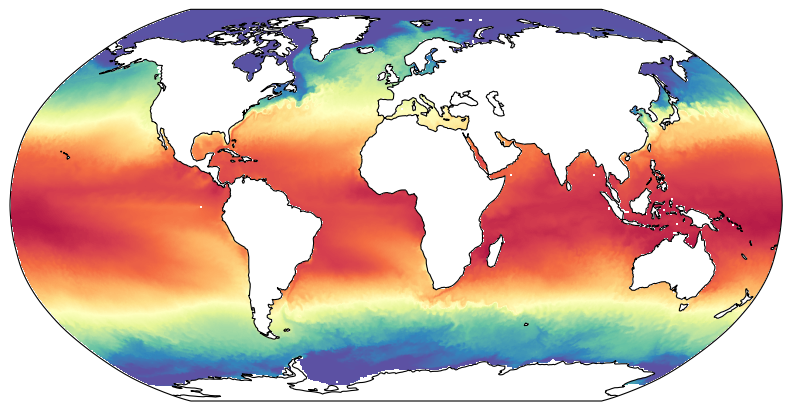

CPU times: user 567 ms, sys: 63.3 ms, total: 630 ms
Wall time: 667 ms


In [11]:
%%time
plot_healpix(data_healpix)

South pole with polar projection 

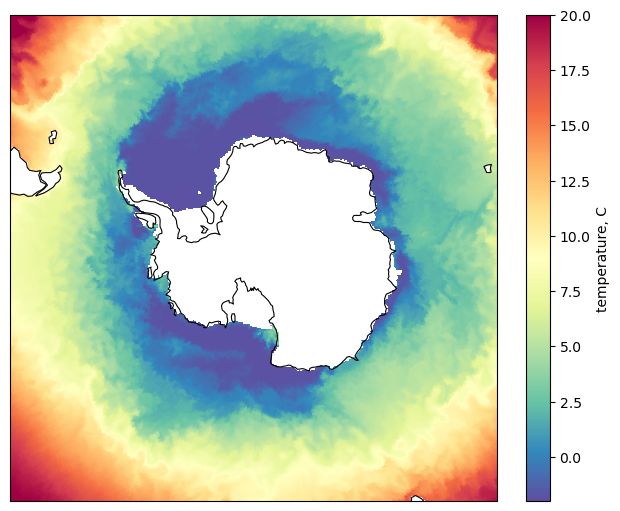

CPU times: user 945 ms, sys: 15.7 ms, total: 961 ms
Wall time: 963 ms


In [12]:
%%time
plot_healpix(data_healpix, extent = [-180,180,-50,-90], proj = 'sp', cbar = True,vmin = -2, vmax = 20)

North Atlantic with mercator projection

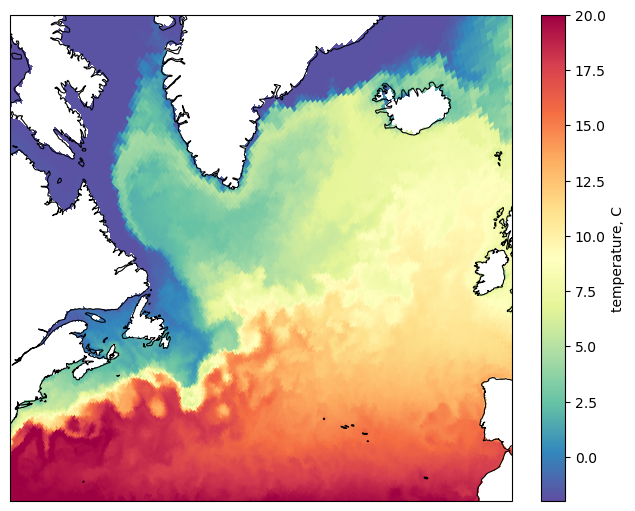

CPU times: user 1.22 s, sys: 18.5 ms, total: 1.24 s
Wall time: 1.24 s


In [13]:
%%time
plot_healpix(data_healpix, extent = [-75,-5,30,70], proj = 'mercator', cbar = True,vmin = -2, vmax = 20)

#### Let's try with higher resolution

In [15]:
%%time
data_healpix_hr,sel_time,sel_depth = to_healpix(data, lon,lat, zoom = 10)

number of healpix_data: 12582912
number of original_data: 8852366
CPU times: user 1min 15s, sys: 2.79 s, total: 1min 18s
Wall time: 1min 18s


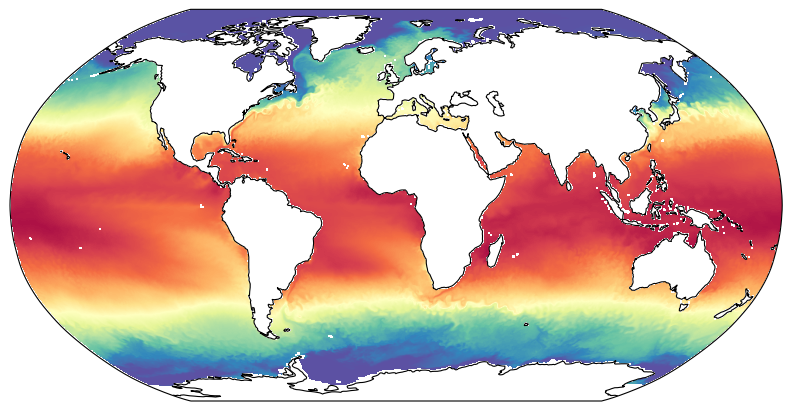

CPU times: user 419 ms, sys: 1.91 ms, total: 421 ms
Wall time: 420 ms


In [16]:
%%time
plot_healpix(data_healpix_hr)

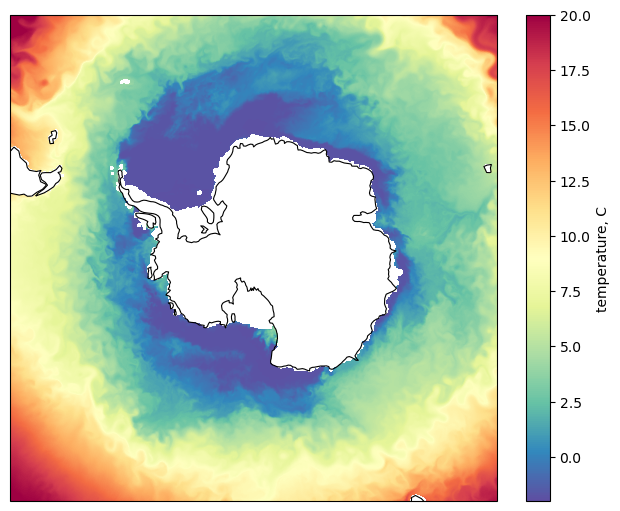

CPU times: user 902 ms, sys: 6.87 ms, total: 909 ms
Wall time: 909 ms


In [17]:
%%time
plot_healpix(data_healpix_hr, extent = [-180,180,-50,-90], proj = 'sp', cbar = True,vmin = -2, vmax = 20)

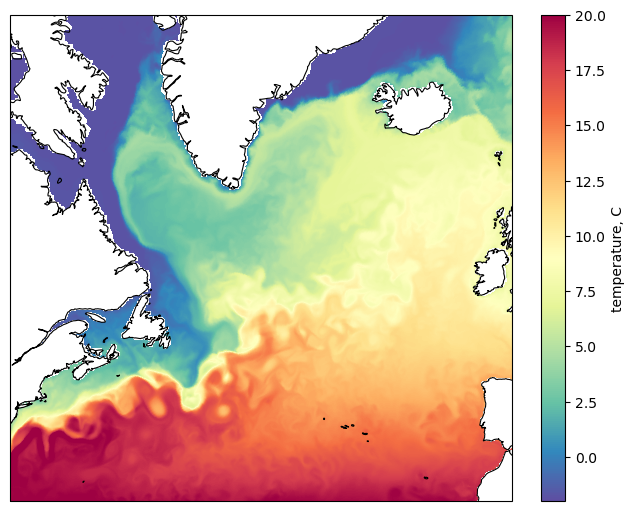

CPU times: user 741 ms, sys: 45.6 ms, total: 787 ms
Wall time: 890 ms


In [18]:
%%time
plot_healpix(data_healpix_hr, extent = [-75,-5,30,70], proj = 'mercator', cbar = True,vmin = -2, vmax = 20)